In [1]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/MyDrive/dataset/train/Normal',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/dataset/train/OSCC',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/dataset/test/Normal',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/dataset/test/OSCC',224))
benign_val = np.array(Dataset_loader('/content/drive/MyDrive/dataset/val/Normal',224))
malign_val = np.array(Dataset_loader('/content/drive/MyDrive/dataset/val/OSCC',224))

100%|██████████| 92/92 [01:20<00:00,  1.14it/s]


In [5]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

#benign_val_label = np.zeros(len(benign_val))
#malign_val_label = np.ones(len(malign_val))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

#X_val = np.concatenate((benign_val, malign_val), axis = 0)
#Y_val = np.concatenate((benign_val_label, malign_val_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)
#Y_val = to_categorical(Y_val, num_classes= 2)

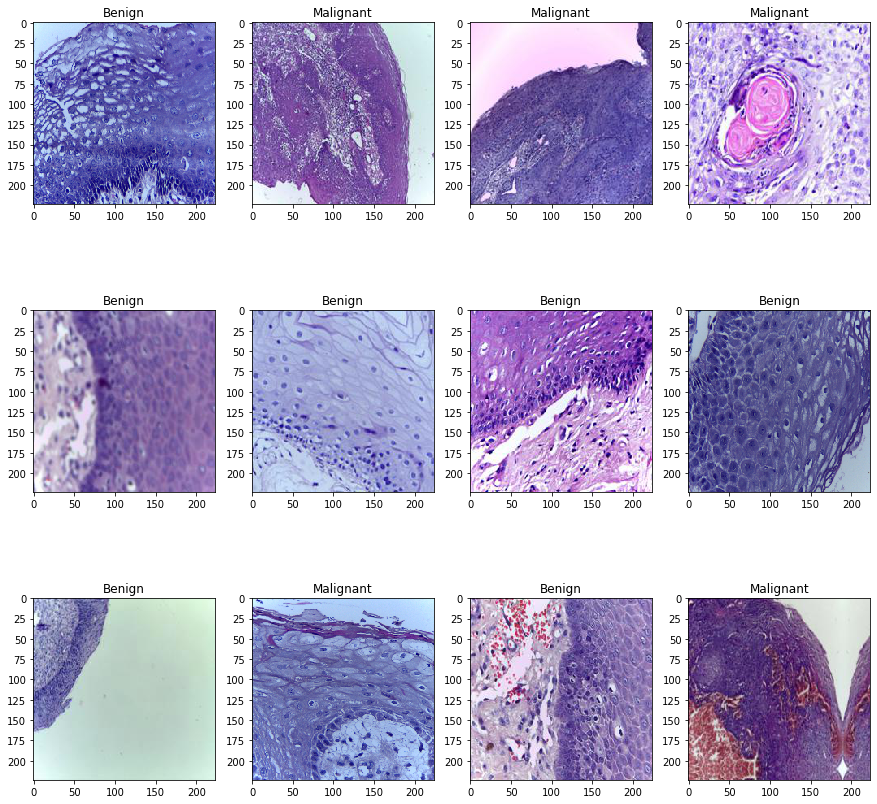

In [8]:
# x_train, x_val, y_train, y_val = train_test_split(
#     X_train, Y_train, 
#     test_size=0.2, 
#     random_state=11

x_train, x_val, y_train, y_val = train_test_split(
  X_train, Y_train,
  test_size=0.2,
  random_state=11
)

x_train=X_train
#x_val=X_val
y_train=Y_train
#y_val=Y_val

w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [11]:
BATCH_SIZE = 32

train_datagen = ImageDataGenerator( 
    zoom_range=2,  # set range for random zoom
    rotation_range = 90,
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip images
)

train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_generator = train_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, shuffle= False)
test_generator = train_datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE, shuffle= False)





def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    return model

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()
     

74836368/74836368 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                         

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
# Set a learning rate annealer
learn_control = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=1e-4)
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-16-b346d15e0cfd>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
155/154 [==============================] - ETA: 0s - loss: 0.2723 - accuracy: 0.8929

154/154 [==============================] - 134s 636ms/step - loss: 0.2723 - accuracy: 0.8929 - val_loss: 0.2224 - val_accuracy: 0.9123 - lr: 1.0000e-04
Epoch 2/10
155/154 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9746

154/154 [==============================] - 91s 587ms/step - loss: 0.0765 - accuracy: 0.9746 - val_loss: 0.0307 - val_accuracy: 0.9889 - lr: 1.0000e-04
Epoch 3/10
155/154 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9883

154/154 [==============================] - 92s 596ms/step - loss: 0.0380 - accuracy: 0.9883 - val_loss: 0.0094 - val_accuracy: 0.9980 - lr: 1.0000e-04
Epoch 4/10
155/154 [==============================] - ETA: 0s - loss: 0.0264 - accuracy: 0.9917

154/154 [==============================] - 93s 600ms/step - loss: 0.0264 - accuracy: 0.9917 - val_loss: 0.0463 - val_accuracy: 0.9829 - lr: 1.0000e-04
Epoch 5/10
155/154 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9871

154/154 [==============================] - 91s 589ms/step - loss: 0.0351 - accuracy: 0.9871 - val_loss: 0.0329 - val_accuracy: 0.9879 - lr: 1.0000e-04
Epoch 6/10
155/154 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9889

154/154 [==============================] - 94s 604ms/step - loss: 0.0296 - accuracy: 0.9889 - val_loss: 0.0657 - val_accuracy: 0.9768 - lr: 1.0000e-04
Epoch 7/10
155/154 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9883

154/154 [==============================] - 94s 605ms/step - loss: 0.0369 - accuracy: 0.9883 - val_loss: 0.0139 - val_accuracy: 0.9970 - lr: 1.0000e-04
Epoch 8/10
155/154 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.9889

154/154 [==============================] - 92s 593ms/step - loss: 0.0354 - accuracy: 0.9889 - val_loss: 0.0272 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 9/10
155/154 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9942

154/154 [==============================] - 93s 599ms/step - loss: 0.0152 - accuracy: 0.9942 - val_loss: 0.0102 - val_accuracy: 0.9970 - lr: 1.0000e-04
Epoch 10/10
155/154 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9946

154/154 [==============================] - 94s 605ms/step - loss: 0.0147 - accuracy: 0.9946 - val_loss: 0.0119 - val_accuracy: 0.9940 - lr: 1.0000e-04


In [ ]:
print(history.history.keys())
import matplotlib.pyplot as plt
acc=(history.history['accuracy'])
loss=(history.history['loss'])
prc=(history.history['precision'])
rec=(history.history['recall'])
auc=(history.history['auc'])
val_acc=(history.history['val_accuracy'])
val_loss=(history.history['val_loss'])
val_prc=(history.history['val_precision'])
val_rec=(history.history['val_recall'])
val_auc=(history.history['val_auc'])

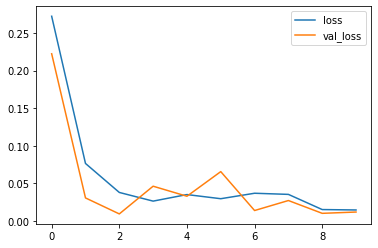

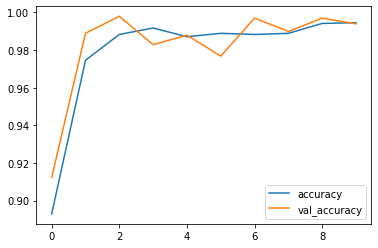

In [17]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [13]:
test_generator.reset()
Y_pred = model.predict_generator(test_generator, steps=np.ceil(X_test.shape[0]/BATCH_SIZE))
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

<ipython-input-13-85113083ca0a>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator, steps=np.ceil(X_test.shape[0]/BATCH_SIZE))


0.4444444444444444

In [14]:
val_generator.reset()
Y_val_pred = model.predict_generator(val_generator, steps=np.ceil(x_val.shape[0]/BATCH_SIZE))
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

<ipython-input-14-096afc8e041e>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_val_pred = model.predict_generator(val_generator, steps=np.ceil(x_val.shape[0]/BATCH_SIZE))


0.5181451612903226

In [15]:
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)

[3.5326244831085205, 0.5873016119003296]


In [16]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    test_generator = train_datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE, shuffle= False)
    preds = model.predict_generator(test_generator, steps=np.ceil(X_test.shape[0]/BATCH_SIZE))
    predictions.append(preds)

    del test_generator
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-16-2d0b73b30e6d>:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, steps=np.ceil(X_test.shape[0]/BATCH_SIZE))
100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


In [17]:
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

0.4444444444444444

In [18]:
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

0.46825396825396826

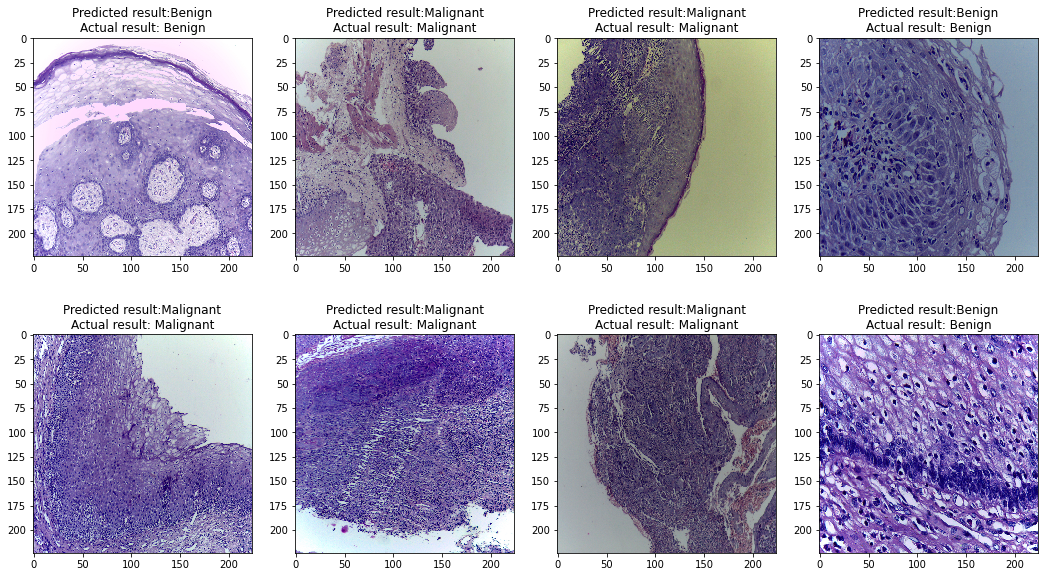

In [19]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

Confusion matrix, without normalization
[[16 15]
 [55 40]]


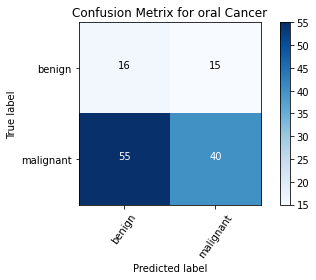

In [20]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar() 
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for oral Cancer')

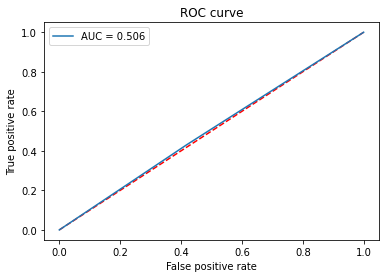

In [21]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

In [22]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1)))

              precision    recall  f1-score   support

           0       0.25      0.58      0.35        31
           1       0.76      0.43      0.55        95

    accuracy                           0.47       126
   macro avg       0.50      0.51      0.45       126
weighted avg       0.63      0.47      0.50       126



In [25]:
def fitandPlot(model, dataAug, trainX, trainY, 
               testX, testY, EPOCHS = 20, INIT_LR = 1e-1, BS = 64):
    
    # Learning Rate Reducer
    learn_control = ReduceLROnPlateau(
                             monitor='val_accuracy',
                             patience=5,
                             verbose=1,factor=0.2, 
                             min_lr=1e-7)
    # Checkpoint
    filepath="weights.best.hdf5"
    checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_accuracy', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='max')
    
    history = model.fit(
    dataAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=trainX.shape[0] / BS,
    epochs=EPOCHS,
    validation_data=(testX, testY),
    callbacks=[learn_control, checkpoint])
    
    plot_history(history)

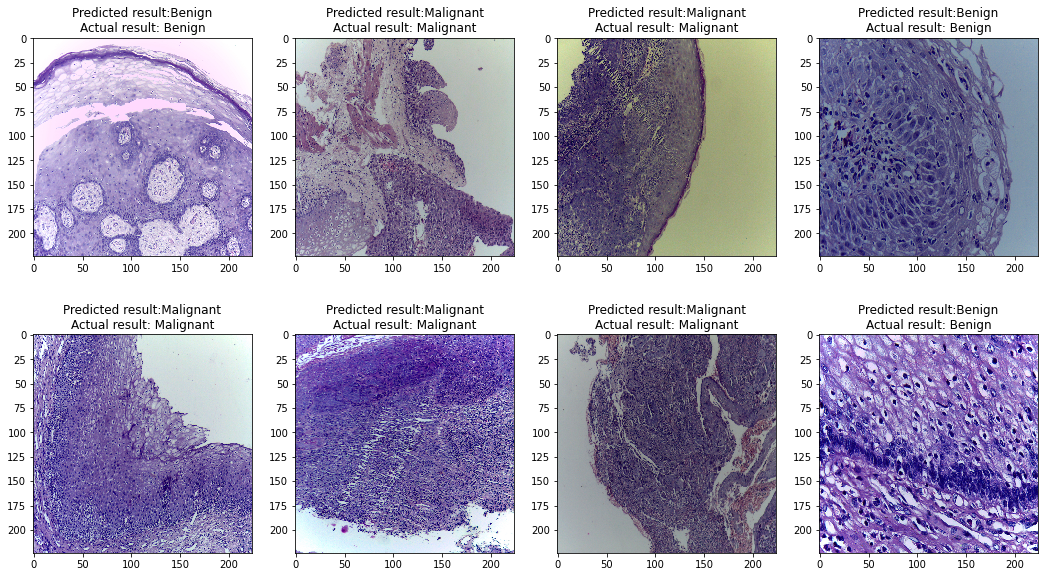

In [23]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()